# U-NET IMPLEMENTATION FOR SEMANTIC IMAGE SEGMENTATION


* Coding: utf-8 
* Description: This notebook makes predictions used a U-net model on images generated by the carla-simulator. The model itself was built with tensorflow according to the archtecture of U-Net v2.  It is not shown here to comply with requirements of the course provider about publication of code. The complete model (architecture, weights and training configuration) was saved to file using tf.keras.Model.save
* Author: dashnisan
* Date Created: March 5, 2024
* Python Version: 3.8.10
* Dependencies: tensorflow, imageio
* Tensorflow Versioin: 2.13.1
* License: MIT License

<img src="images/U-net_v2_paper.png" style="width:700px;height:350;">
<caption><center> Diagram of U-Net v2 according to its authors. Source: https://arxiv.org/abs/2311.17791 <br> </center></caption>


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio.v2 as imageio

2024-03-05 12:33:19.360963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 12:33:19.398698: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 12:33:19.399361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 12:33:20.101128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# LOAD SAVED MODEL AND CHECK ARCHITECTURE OF U-NET

In [3]:
# load model:
unet = tf.keras.models.load_model('./model/unetv2_64f_5epo.keras')
unet.summary()

2024-03-05 12:33:21.304315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 12:33:21.305616: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 96, 128, 64)          1792      ['input_6[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 96, 128, 64)          36928     ['conv2d_26[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 48, 64, 64)           0         ['conv2d_27[0][0]']           
 g2D)                                                                                       

# LOAD DATA TO MAKE PREDICTIONS AND PREPROCESS THE IMAGES
* The predictions are made on the training set itself
* The dataset used for this exercise was generated with carla-simulator: https://github.com/carla-simulator/carla


In [4]:
# load data
path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

# Split data into unmasked and masked images:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [5]:
print('Number of images in training data set: {}'.format(len(image_list)))
print('Number of segmentation masks in training data set: {}'.format(len(mask_list)))
print('Sahpe of images in training data set: {}'.format( imageio.imread(image_list[0]).shape))
print('Shape of images in training data set: {}'.format( imageio.imread(mask_list[0]).shape))

Number of images in training data set: 1060
Number of segmentation masks in training data set: 1060
Sahpe of images in training data set: (480, 640, 4)
Shape of images in training data set: (480, 640, 4)


In [6]:
def process_path(image_path, mask_path):
    '''
    Normalize pixels to [0,1]
    Turn png images and masks into float tensors
    Get the maximum values along channels for the masks and reduce them
    '''
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

In [7]:
def preprocess(image, mask):
    ''' reduce image size'''
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

In [8]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# FUNCTIONS FOR DISPLAYING PREDICTIONS

In [9]:
def create_mask(pred_mask):
    '''function that uses tf.argmax in the axis of the number of classes to return the 
    index with the largest value and merge the prediction into a single image:
    '''
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [10]:
def display(display_list):
    '''
    displays the original image, the label mask and the predicted mask
    '''
    
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [11]:
def show_predictions(model='unet', dataset=None, num_batches=1):
    """
    Displays the first image of each of the num_batches:
    Downsampled image as processed by model, label mask and predicted mask
    """
    if dataset:
        for image, mask in dataset.take(num_batches):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# SHOW PREDICTIONS FOR SOME IMAGES

1/1 [==============================] - 3s 3s/step


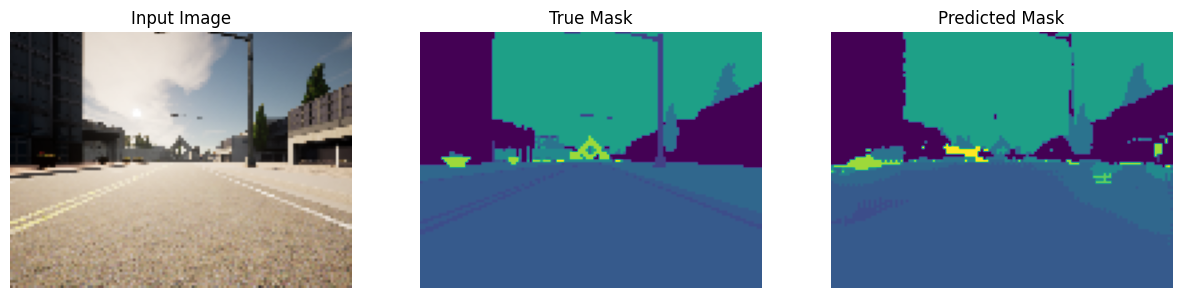

1/1 [==============================] - 3s 3s/step


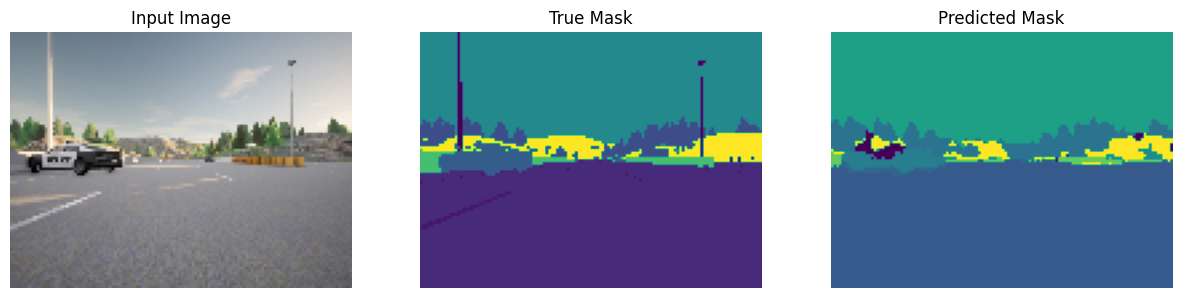

1/1 [==============================] - 3s 3s/step


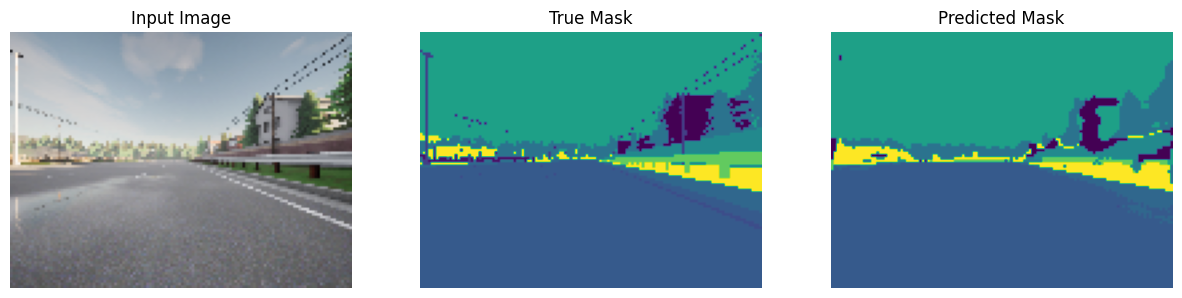

1/1 [==============================] - 3s 3s/step


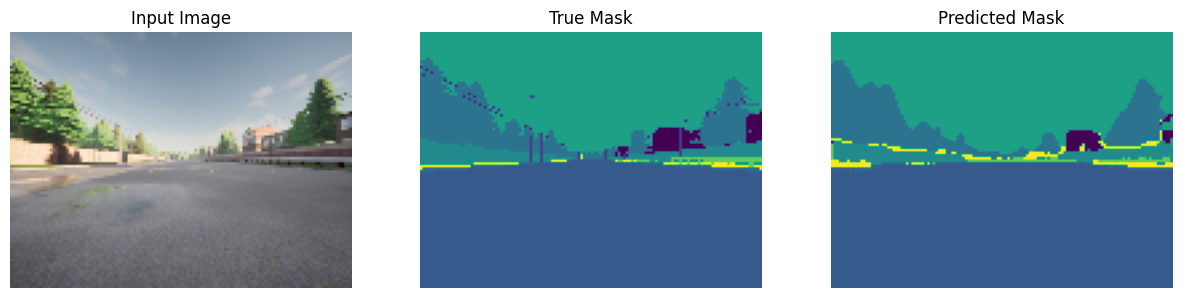

1/1 [==============================] - 3s 3s/step


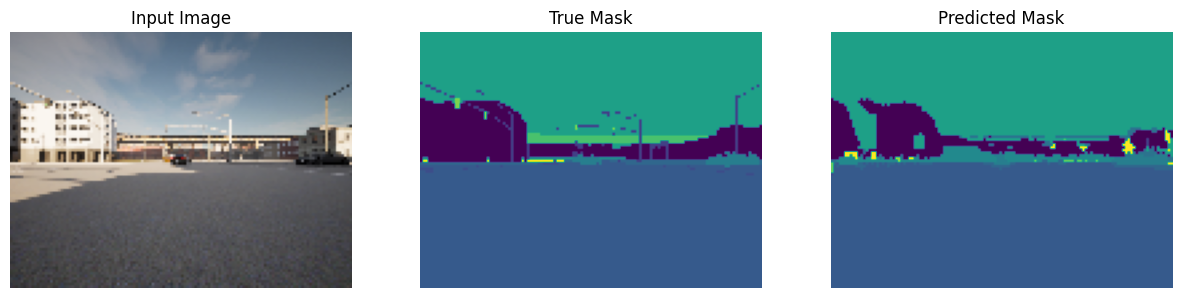

1/1 [==============================] - 3s 3s/step


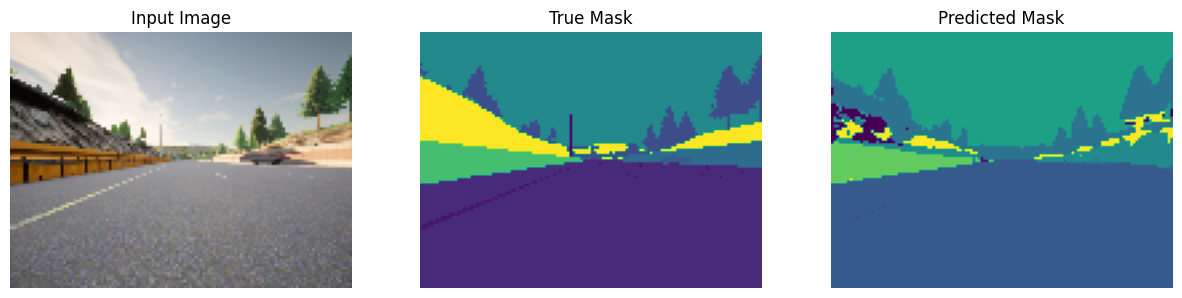

2024-03-05 12:33:53.762410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 3s 3s/step


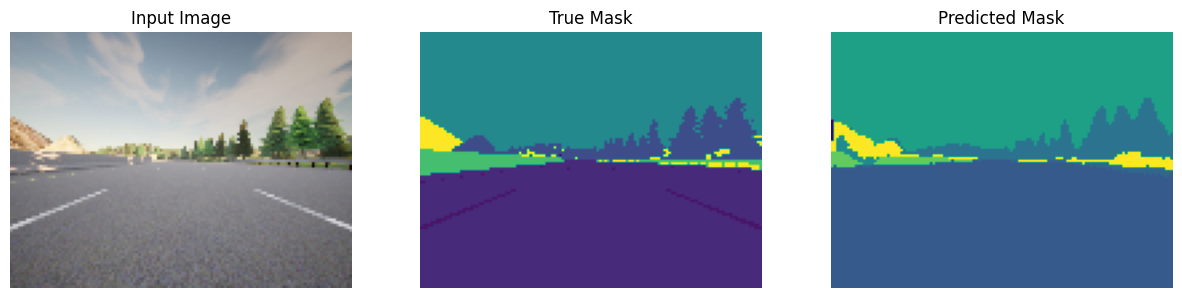

In [12]:
show_predictions(unet, train_dataset, num_batches=7)

# OBSERVATIONS

* The predictions were made on the train set itself
* The training was made with only 5 epochs and following the parameters of the U-Net v2 as seen here: https://arxiv.org/abs/2311.17791
* The model tends to overfitting: Details of structurtes like cars and buildings are differentiated